# **Bank Review/Complaint Analysis**

Central banks collect information about customer satisfaction with the services provided by different banks as well as their complaints.

Bank users give ratings and write reviews about the services on central bank websites. These reviews and ratings help banks evaluate services provided and take necessary action to improve customer service. While ratings are useful to convey the overall experience, they do not convey the context which led a reviewer to that experience.
* If we look at only the rating, it is difficult to guess why the user rated the service as 4 stars. However, after reading the review, it is not difficult to identify that the review talks about good 'service' and 'experience'.


<img src="https://img.etimg.com/thumb/width-1600,height-900,imgsize-74284,resizemode-75,msid-107782155/industry/banking/finance/banking/banks-to-conduct-performance-review-of-empanelled-advocates.jpg" height="400" width="700">

### **Data Schema**
The data is detailed dump of customer reviews /complaints (~500) of different services at different banks.

- Date - Day of the posted review
- Stars - Rating given by the customer for the service provided on 1-5 scale
- Reviews - Reviews/Complaints by customers
- Bank Name - Name of the Bank being reviewed

### **Objective:**
To analyze customer reviews and predict customer sentiment with the reviews.


**Import necesssary libraries**

In [2]:
!pip install -U textblob
!pip install vaderSentiment
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import string

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


**nltk.download('punkt'):**

Purpose: This command downloads the Punkt tokenizer models, which are used for dividing a text into a list of sentences and further into a list of words.

**nltk.download('averaged_perceptron_tagger'):**

Purpose: This command downloads the averaged perceptron tagger, which is used for part-of-speech (POS) tagging. POS tagging assigns a part of speech (like noun, verb, adjective, etc.) to each word in a sentence.

**nltk.download('vader_lexicon'):**

Purpose: This command downloads the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon, which is a list of lexical features commonly used in sentiment analysis.

**TextBlob:**

TextBlob is a Python library for processing textual data.

In [15]:
#from google.colab import drive   # Drive mount
#drive.mount('/content/drive')

**Import the data set**

In [4]:
customer = pd.read_csv('/content/BankReviews.csv', encoding='windows-1252' )

In [5]:
customer.head()

,Date,Stars,Reviews,BankName
0,10-04-2017,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,10-02-2017,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,21-08-2017,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,17-12-2017,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,27-05-2016,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [6]:
customer.tail()

,Date,Stars,Reviews,BankName
500,06-02-2016,1,\r\nI never write reviews but had to this time...,North American Savings Bank
501,25-07-2016,1,\r\nIt all started when Bob G ran a credit che...,North American Savings Bank
502,27-09-2017,1,\r\nWhat a horrible experience. We have excell...,North American Savings Bank
503,24-12-2017,1,"\r\nRep was extremely professional, friendly, ...",North American Savings Bank
504,19-03-2017,1,\r\nI was working with a loan consultant from ...,North American Savings Bank


In [7]:
customer['Reviews'] = customer['Reviews'].apply(lambda x: x.replace('\r','').strip())
customer.tail()

,Date,Stars,Reviews,BankName
500,06-02-2016,1,I never write reviews but had to this time to ...,North American Savings Bank
501,25-07-2016,1,It all started when Bob G ran a credit check w...,North American Savings Bank
502,27-09-2017,1,What a horrible experience. We have excellent ...,North American Savings Bank
503,24-12-2017,1,"Rep was extremely professional, friendly, and ...",North American Savings Bank
504,19-03-2017,1,I was working with a loan consultant from NASB...,North American Savings Bank


**Data Audit**

In [8]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      505 non-null    object
 1   Stars     505 non-null    int64 
 2   Reviews   505 non-null    object
 3   BankName  505 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.9+ KB


In [9]:
customer.shape

(505, 4)

In [10]:
customer.isnull().sum()

Date        0
Stars       0
Reviews     0
BankName    0
dtype: int64

In [11]:
customer['Stars'].value_counts()

Stars
5    410
1     95
Name: count, dtype: int64

## **Sentiment Analysis**

- Sentiment Analysis (also known as opinion mining or emotion AI) is a sub-field of NLP that measures the inclination of people’s opinions (Positive/Negative/Neutral) within the unstructured text
- It can be performed using two approaches: Rule-based and Machine Learning based

### **Rule-based approach**
This is a practical approach to analyzing text without training or using machine learning models. The result of this approach is a set of rules based on which the text is labeled as positive/negative/neutral. These rules are also known as lexicons. Hence, the Rule-based approach is otherwise called Lexicon based approach.
Some widely used lexicon-based approaches are `TextBlob and VADER`.

For lexicon-based approaches, a sentiment is defined by its semantic orientation and the intensity of each word in the sentence. This requires a pre-defined dictionary classifying negative and positive words. Generally, a text message will be represented by bag of words. After assigning individual scores to all the words, final sentiment is calculated by some pooling operation such as taking an average of all the sentiments.

### **Learning based approach**
In contrast to rule-based systems, learning systems have a very ambitious goal. A learning system is, in principle, unlimited in its ability to simulate intelligence. It’s said to have adaptive intelligence. The ability to learn causes adaptive intelligence, and adaptive intelligence means that existing knowledge can be changed or discarded, and new knowledge can be acquired. Hence, these systems build the rules on the fly. That is what makes learning systems so different from rule-based testing. Sentiment analysis models can be trained to read beyond mere definitions, to understand things like, context, sarcasm, and misapplied words. One such commonly used ML algorithm is `Naive Bayes`.

In [12]:
X = customer['Reviews']

In [13]:
X.head()

0    Great job, Wyndham Capital! Each person was pr...
1    Matthew Richardson is professional and helpful...
2    We had a past experience with Wyndham Mortgage...
3    We have been dealing with Brad Thomka from the...
4    I can't express how grateful I am for the supp...
Name: Reviews, dtype: object

### **TextBlob**

TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. It's built upon NLTK and provides an easy to use interface to the NLTK library.

* TextBlob returns polarity and subjectivity of a sentence.
Polarity lies between [-1,1], where -1 defines a negative sentiment and 1 defines a positive sentiment. Negation words reverse the polarity.

* TextBlob has semantic labels that help with fine-grained analysis. For example — emoticons, exclamation mark, emojis, etc. Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

* TextBlob has one more parameter — intensity. TextBlob calculates subjectivity by looking at the ‘intensity’. Intensity determines if a word modifies the next word. For English, adverbs are used as modifiers (‘very good’).

In [16]:
# UDF to find sentiment polarity of the reviews
def sentiment_review(text):
    analysis = TextBlob(text)
    polarity_text = analysis.sentiment.polarity
    if polarity_text > 0:
        return 'Positive'
    elif polarity_text == 0:
        return 'Neutral'
    else:
        return 'Negative'

In [17]:
# creating dictionary which will contain both the review and the sentiment of the review
final_dictionary = []
for text in X:
    dictionary_sentiment = {}
    dictionary_sentiment['Review'] = text
    dictionary_sentiment['Sentiment'] = sentiment_review(text)
    final_dictionary.append(dictionary_sentiment)
print(final_dictionary[:5])

[{'Review': 'Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!', 'Sentiment': 'Positive'}, {'Review': 'Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!', 'Sentiment': 'Positive'}, {'Review': 'We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind', 'Sentiment': 'Negative'}, {'Review': 'We have been dealing with Brad Thomka from the beginning of what started out to be a very stressful time for us, but 

In [18]:
# Finding positive reviews
positive_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Positive':
        positive_reviews.append(review)
print(positive_reviews[:5])


[{'Review': 'Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!', 'Sentiment': 'Positive'}, {'Review': 'Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!', 'Sentiment': 'Positive'}, {'Review': 'We have been dealing with Brad Thomka from the beginning of what started out to be a very stressful time for us, but with the help from Brad and the entire Wyndham Mortgage team it was turned into a happy ending!! Brad and Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled\xa0together and found a viable option for us that ultimately saved us money. We are indebted and would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & LindRead Less', 'Sentimen

In [19]:
# Finding neutral reviews
neutral_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Neutral':
        neutral_reviews.append(review)
print(neutral_reviews[:5])

[{'Review': 'Person with whom I spoke kept interrupting me and telling me his "line" rather than listening to what info I wanted. Quite pushy, altho\' he said he wasn\'t a salesman. Closing costs were astronomical.', 'Sentiment': 'Neutral'}, {'Review': 'The rate re-lock-in rule was not followed.', 'Sentiment': 'Neutral'}, {'Review': "Lending tree matching me up with companies that don't offer the product I requested.", 'Sentiment': 'Neutral'}, {'Review': 'They called me and asked about the city in NH that we where looking at and when I told him we might consider MA as well he hung up on me.', 'Sentiment': 'Neutral'}]


In [20]:
# Finding negative reviews
negative_reviews = []
for review in final_dictionary:
    if review['Sentiment'] =='Negative':
        negative_reviews.append(review)
print(negative_reviews[:5])

[{'Review': 'We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind', 'Sentiment': 'Negative'}, {'Review': 'This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The appraiser that they hired made so many mistakes I had to send in corrections and then during the underwriting process they had to go back and make more corrections. Wyndum would continue to ask for copies of documents over and over again. There were many documents that I had to send 3 a

In [21]:
# counting number of positive,neutral and negative reviews
reviews_count = pd.DataFrame([len(positive_reviews),len(neutral_reviews),len(negative_reviews)],index=['Positive','Neutral','Negative'])

In [22]:
reviews_count

,0
Positive,466
Neutral,4
Negative,35


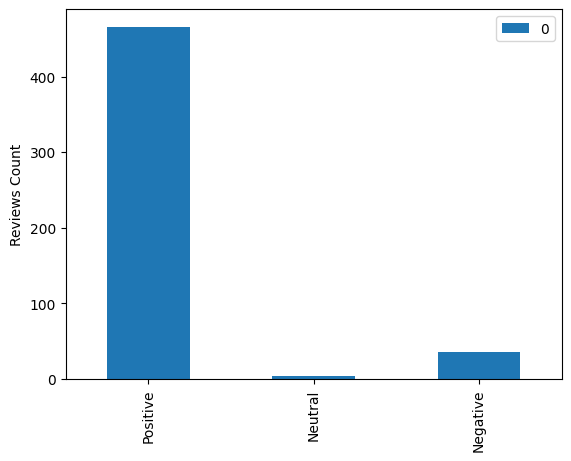

In [23]:
reviews_count.plot(kind='bar')
plt.ylabel('Reviews Count')
plt.show()

The graph represent higher positive review counts.

In [24]:
# printing first five positive reviews
i=1
for review in positive_reviews[:5]:
        print(i)
        print(review['Review'])
        print('******************************************************')
        i+=1

1
Great job, Wyndham Capital! Each person was professional and helped us move through our refinance process smoothly. Thank you!
******************************************************
2
Matthew Richardson is professional and helpful. He helped us find the correct product for our mortgage. Thank you very much for the excellent service, Matthew!
******************************************************
3
We have been dealing with Brad Thomka from the beginning of what started out to be a very stressful time for us, but with the help from Brad and the entire Wyndham Mortgage team it was turned into a happy ending!! Brad and Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We are indebted and would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & LindR

In [25]:
# printing first five negative reviews
i=1
for review in negative_reviews[:5]:
        print(i)
        print(review['Review'])
        print('******************************************************')
        i+=1

1
We had a past experience with Wyndham Mortgage and would without question use again and again if needed!! Wyndham went beyond the extra mile to not only right a wrong encountered from the servicer we were dealing on our previous loan, but they pulled together and found a viable option for us that ultimately saved us money. We would highly recommend Brad Thomka and the Wyndham Capital Mortgage team for your mortgage needs. Sincerest thanks Wyndham!! Ed & Lind
******************************************************
2
This was the worst experience ever. It was like they had never gone through the process before. I could not get a complete list of the documents required. Every other day it was a new request. The appraiser that they hired made so many mistakes I had to send in corrections and then during the underwriting process they had to go back and make more corrections. Wyndum would continue to ask for copies of documents over and over again. There were many documents that I had to se

In [26]:
# function to analyze subjectivity in reviews
def review_subjectivity(text):
    sub_analysis = TextBlob(text)
    subjectivity_text = sub_analysis.sentiment.subjectivity
    return subjectivity_text

The review_subjectivity function leverages the TextBlob library to quantify the subjectivity of a given text, helping to determine whether the text is more opinion-based or fact-based. This can be particularly useful in sentiment analysis, content categorization, and understanding the tone of user-generated content like reviews.

In [27]:
# creating dictionary which will contain both the review and its subjectivity
sub_dictionary = []
for text in X:
    dictionary_subjectivity = {}
    dictionary_subjectivity['Review'] = text
    dictionary_subjectivity['Subjectivity'] = review_subjectivity(text)
    sub_dictionary.append(dictionary_subjectivity)

In [28]:
# creating dataframe of reviews and subjectivity
subjectivity_df = pd.DataFrame.from_records(sub_dictionary)
subjectivity_df.head()

,Review,Subjectivity
0,"Great job, Wyndham Capital! Each person was pr...",0.450000
1,Matthew Richardson is professional and helpful...,0.453333
2,We had a past experience with Wyndham Mortgage...,0.521376
3,We have been dealing with Brad Thomka from the...,0.536171
4,I can't express how grateful I am for the supp...,0.235000


**Note:** The subjectivity is TextBlob's score of whether the statement is deemed as more opinion, or fact based. A higher subjectivity score means it is less objective, and therefore would be highly opinionated.

In [29]:
# analyzing fact-based negative reviews
subjectivity_df_sorted = subjectivity_df.sort_values('Subjectivity', ignore_index=True)
subjectivity_df_sorted.head()

,Review,Subjectivity
0,Person with whom I spoke kept interrupting me ...,0.0
1,Lending tree matching me up with companies tha...,0.0
2,They called me and asked about the city in NH ...,0.0
3,Based on results I have to give 1 star. My ini...,0.0
4,The rate re-lock-in rule was not followed.,0.0


In [30]:
for i in subjectivity_df_sorted['Review'][0:5]:
    print(i)
    print('********************')

Person with whom I spoke kept interrupting me and telling me his "line" rather than listening to what info I wanted. Quite pushy, altho' he said he wasn't a salesman. Closing costs were astronomical.
********************
Lending tree matching me up with companies that don't offer the product I requested.
********************
They called me and asked about the city in NH that we where looking at and when I told him we might consider MA as well he hung up on me.
********************
Based on results I have to give 1 star. My initial conversations was over the course of an hour. I provided all my info and based on that Anthony said he would give me 3 options moving forward. The next day we talked he had zero options for me and said I wasn't approved.  It was a waste of a credit pull.
********************
The rate re-lock-in rule was not followed.
********************


### **VADER**

- VADER stands for `Valence Aware Dictionary and Sentiment Reasoner`.

It is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. VADER uses a combination of a sentiment lexicon, a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

VADER has a lot of advantages over traditional methods of Sentiment Analysis, including:
- It works exceedingly well on social media type text, yet readily generalizes to multiple domains
- It doesn’t require any training data but is constructed from a generalizable, valence-based, human-curated gold standard sentiment lexicon
- It is fast enough to be used online with streaming data
- It does not severely suffer from a speed-performance tradeoff



VADER’s SentimentIntensityAnalyzer method takes in a string and returns a dictionary of scores in each of four categories:
- `negative`
- `neutral`
- `positive`
- `compound` (computed by normalizing the above scores)


><img src="https://media.licdn.com/dms/image/D5612AQHBEuzyC7Kuwg/article-cover_image-shrink_423_752/0/1702005219023?e=1726099200&v=beta&t=FslgRxIybOXYBU5Ye-1nfYrgZHEAivRR3OoM0LtCMlU">

The Positive, Negative and Neutral scores represent the proportion of text that falls in these categories while the Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive).

In [31]:
analyzer = SentimentIntensityAnalyzer()
df = customer[['Reviews']]
df['Scores'] = df['Reviews'].apply(lambda review: analyzer.polarity_scores(review))
df.head()

,Reviews,Scores
0,"Great job, Wyndham Capital! Each person was pr...","{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp..."
1,Matthew Richardson is professional and helpful...,"{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp..."
2,We had a past experience with Wyndham Mortgage...,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp..."
3,We have been dealing with Brad Thomka from the...,"{'neg': 0.018, 'neu': 0.756, 'pos': 0.226, 'co..."
4,I can't express how grateful I am for the supp...,"{'neg': 0.04, 'neu': 0.861, 'pos': 0.099, 'com..."


In [32]:
df['Compound Score']  = df['Scores'].apply(lambda score_dict: score_dict['compound'])
df.head()

,Reviews,Scores,Compound Score
0,"Great job, Wyndham Capital! Each person was pr...","{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp...",0.8011
1,Matthew Richardson is professional and helpful...,"{'neg': 0.0, 'neu': 0.703, 'pos': 0.297, 'comp...",0.8516
2,We had a past experience with Wyndham Mortgage...,"{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...",0.9595
3,We have been dealing with Brad Thomka from the...,"{'neg': 0.018, 'neu': 0.756, 'pos': 0.226, 'co...",0.9818
4,I can't express how grateful I am for the supp...,"{'neg': 0.04, 'neu': 0.861, 'pos': 0.099, 'com...",0.5569


### **Finding most frequently used Positive/ Negative words**

### **Data Preprocessing**

In [33]:
# X = customer['Reviews']
X.head()

0    Great job, Wyndham Capital! Each person was pr...
1    Matthew Richardson is professional and helpful...
2    We had a past experience with Wyndham Mortgage...
3    We have been dealing with Brad Thomka from the...
4    I can't express how grateful I am for the supp...
Name: Reviews, dtype: object

In [34]:
# UDF to remove the noun tags from the text
def get_noun_tags(text):
    tokens = word_tokenize(text)
    tokens = " ".join([word for (word, pos) in nltk.pos_tag(tokens) if(pos != 'NN') and (pos != 'NNP') and (pos != 'NNS')
                     and (pos != 'NNPS')])
    return tokens

**Note:** A User-Defined Function (UDF) is a function created by the user to perform specific tasks that are not built into the standard library of a programming language or environment. In the context of data processing and analysis, UDFs are particularly useful for custom operations on data, such as text manipulation, calculations, or data transformations.

In [35]:
X = X.apply(lambda y: get_noun_tags(y))

In [36]:
X.head()

0    , ! Each was professional and helped us move t...
1    is professional and helpful . He helped us fin...
2    We had a past with and would without again and...
3    We have been dealing with from the of what sta...
4    I ca n't express how grateful I am for the tha...
Name: Reviews, dtype: object

In [37]:
# UDF to clean the reviews
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = "".join([char for char in text if char not in string.punctuation])
    return text

In [38]:
# applying clean_text function defined above to remove punctuation, strip extra spaces and convert each word to lowercase
X = X.apply(lambda y: clean_text(y))

In [39]:
X.head()

0      each was professional and helped us move thr...
1    is professional and helpful  he helped us find...
2    we had a past with and would without again and...
3    we have been dealing with from the of what sta...
4    i ca nt express how grateful i am for the that...
Name: Reviews, dtype: object

### **Coverting reviews to tokens**

In order to use textual data for predictive modeling, the text must be parsed to remove certain words – this process is called tokenization. These words need to then be encoded as integers, or floating-point values, for use as inputs in machine learning algorithms. This process is called feature extraction (or vectorization).

CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.

In [40]:
tokens_vect = CountVectorizer(stop_words='english')

In [41]:
token_dtm = tokens_vect.fit_transform(X)

In [42]:
tokens_vect.get_feature_names_out()

array(['10', '100', '101', ..., 'yep', 'yes', 'zero'], dtype=object)

In [43]:
token_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [44]:
token_dtm.toarray().shape

(505, 1398)

In [45]:
len(tokens_vect.get_feature_names_out())

1398

In [46]:
pd.DataFrame(token_dtm.toarray(),columns = tokens_vect.get_feature_names_out())

,10,100,101,1014,1031,1040s,11,12,13,15,...,worth,wouldn,wouldnt,write,writing,written,wrong,yep,yes,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
print(token_dtm)

  (0, 934)	1
  (0, 606)	1
  (0, 1147)	1
  (0, 1247)	1
  (1, 934)	1
  (1, 606)	1
  (1, 607)	1
  (1, 316)	1
  (1, 455)	1
  (2, 870)	1
  (2, 806)	1
  (2, 1370)	1
  (2, 476)	1
  (2, 1065)	1
  (2, 1394)	1
  (2, 427)	1
  (2, 341)	1
  (2, 923)	1
  (2, 949)	1
  (2, 1344)	1
  (2, 1294)	1
  (2, 1080)	1
  (2, 615)	1
  (2, 994)	1
  (2, 1133)	1
  :	:
  (504, 256)	1
  (504, 214)	1
  (504, 33)	1
  (504, 697)	1
  (504, 218)	1
  (504, 390)	1
  (504, 122)	1
  (504, 142)	2
  (504, 987)	1
  (504, 47)	1
  (504, 518)	1
  (504, 1268)	2
  (504, 24)	2
  (504, 30)	1
  (504, 54)	2
  (504, 778)	2
  (504, 624)	2
  (504, 163)	1
  (504, 1221)	1
  (504, 703)	1
  (504, 460)	1
  (504, 49)	1
  (504, 1037)	2
  (504, 1178)	1
  (504, 381)	1


In [48]:
# creating a dataframe which shows the count of how many times a word is coming in the corpus
count_dtm_dataframe = pd.DataFrame(np.sum(token_dtm.toarray(),axis=0),tokens_vect.get_feature_names_out()).reset_index()
count_dtm_dataframe.columns =['Word','Count']

In [49]:
count_dtm_dataframe.head()

,Word,Count
0,10,10
1,100,9
2,101,1
3,1014,1
4,1031,2


In [50]:
#adding sentiment column which shows sentiment polarity of each word
sentiment_word = []
for word in count_dtm_dataframe['Word']:
    sentiment_word.append(sentiment_review(word))
count_dtm_dataframe['Sentiment'] = sentiment_word

In [51]:
count_dtm_dataframe.tail(20)

,Word,Count,Sentiment
1378,wonder,1,Neutral
1379,wonderful,14,Positive
1380,wonderfully,2,Positive
1381,work,109,Neutral
1382,worked,83,Neutral
1383,working,72,Neutral
1384,works,10,Neutral
1385,worry,2,Neutral
1386,worse,2,Negative
1387,worst,4,Negative


In [52]:
# separating positive words
positive_words_df= count_dtm_dataframe.loc[count_dtm_dataframe['Sentiment']=='Positive',:].sort_values('Count',ascending=False)

In [53]:
positive_words_df.head(20)

,Word,Count,Sentiment
573,great,109,Positive
185,best,91,Positive
934,professional,67,Positive
409,easy,58,Positive
615,highly,56,Positive
1222,sure,51,Positive
60,able,47,Positive
568,good,38,Positive
593,happy,37,Positive
544,friendly,35,Positive


### **Word Cloud**

Word Cloud or Tag Clouds is a visualization technique for texts that are natively used for visualizing the tags or keywords from the websites. These keywords typically are single words that depict the context of the webpage the word cloud is being made from. These words are clustered together to form a Word Cloud.

><img src="https://thumbs.dreamstime.com/b/teamwork-word-cloud-white-background-teamwork-word-cloud-105022635.jpg" height="400" width="600">

Each word in this cloud has a variable font size and color tone. Thus, this representation helps to determine words of prominence. A bigger font size of a word portrays its prominence more relative to other words in the cluster. Word Cloud can be built in varying shapes and sizes based on the creators’ vision. The number of words plays an important role while creating a Word Cloud. More number of words does not always mean a better Word Cloud as it becomes cluttery and difficult to read. A Word Cloud must always be semantically meaningful and must represent what it is meant for.

Although, there are different ways by which Word Clouds can be created but the most widely used type is by using the Frequency of Words in our corpus.

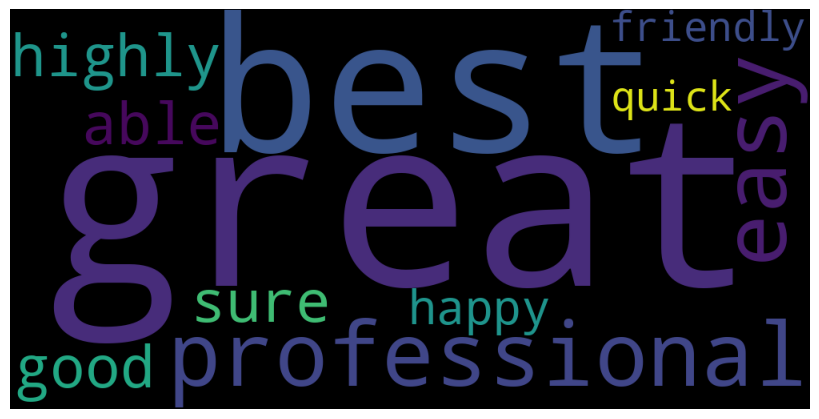

In [54]:
# plotting word cloud of 10 most frequently used positive words
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positive_words_df.iloc[0:11,0]))
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [55]:
# separating negative words
negative_words_df= count_dtm_dataframe.loc[count_dtm_dataframe['Sentiment']=='Negative',:].sort_values('Count',ascending=False)

In [56]:
negative_words_df.head(10)

,Word,Count,Sentiment
253,closed,68,Negative
478,extremely,46,Negative
595,hard,40,Negative
905,poor,18,Negative
281,complicated,18,Negative
737,little,14,Negative
923,previous,13,Negative
460,expected,11,Negative
1170,spent,11,Negative
711,late,11,Negative


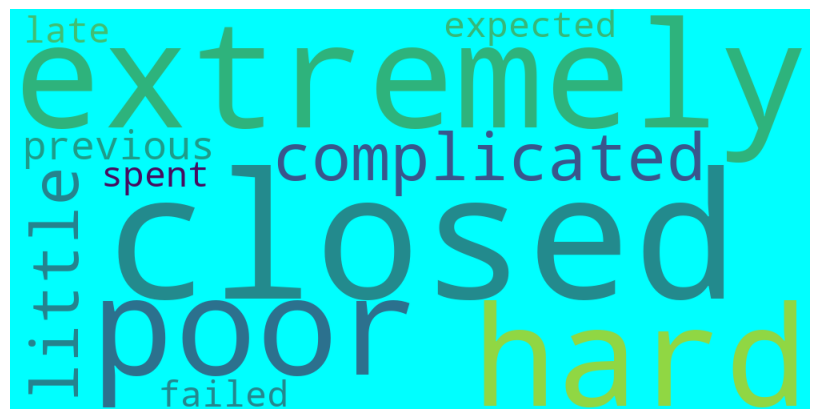

In [57]:
# plotting word cloud of 10 most frequently used negative words
wordcloud = WordCloud(width = 1000, height = 500, background_color='cyan').generate(' '.join(negative_words_df.iloc[0:11,0]))
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### **TextBlob vs VADER**

Offering a greater ease-of-use and a less oppressive learning curve, TextBlob is an attractive and relatively lightweight Python 2/3 library for NLP and sentiment analysis development.

The project provides a more accessible interface compared to the capabilities of NLTK, and also leverages the Pattern web mining module from the University of Antwerp. Combining these resources makes it easy to switch between the capable Pattern library and, for example, a pre-trained NLTK model.

TextBlob has a rule-based integrated sentiment analysis function with two properties—subjectivity and polarity. Workflows with TextBlob and VADER are among the most popular approaches to sentiment analysis with TextBlob.

Given its design and goals, it's not surprising that TextBlob in itself has few functional characteristics to distinguish it from its competitors. It's capable and full-featured, but in terms of speed remains dependent on its external resources, neither of which are exemplary in this respect.

However, certain operations, such as extracting noun phrases, become notably less tortuous in TextBlob as compared to its rivals. It also provides a convenient native wrapper around the Google Translate API.

TextBlob expects ASCII text input by default, and could throw arcane errors if it doesn’t get it. Therefore, your project may need a stratum of decode libraries or functions to keep the wheels moving.

If your workflow involves the processing of CSV files, it's worth observing that Unicode input isn't supported with TextBlob running on Python 2. If you're unable to switch to Python 3, your pipeline may need to convert CSVs into the UTF-8 format.

Since they're rolled into the package, the capabilities and limitations of Pattern are also a factor when evaluating TextBlob for our project. Pattern runs slower than SpaCy, for instance. You'll also need to check that TextBlob’s native sentiment analysis functionality fits your project needs, and whether third-party libraries or modules are available to address any shortfall.

So long as you consider the scope as well as the latency and scalability requirements of your project, `TextBlob could be the quickest way to resolve a modular challenge in a larger pipeline.`

Both libraries offer a host of features — it’s best to try to run some sample data on your subject matter to see which performs best for your requirements.
`VADER is optimized for social media data and can yield good results when used with data from twitter, facebook, etc., whereas TextBlob performs strongly with more formal language usage.`


### **Splitting the data into train and test**

In [58]:
customer['Sentiment'] = customer['Reviews'].apply(sentiment_review)

In [59]:
def sentiment_encoding(sentiment):
    if sentiment == 'Negative':
        return 0
    elif sentiment == 'Neutral':
        return 1
    else:
        return 2

customer['Sentiment_Label'] = customer['Sentiment'].apply(sentiment_encoding)

In [60]:
# input features are the pre-processed reviews as seen in the above section
Y = customer['Sentiment_Label']
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,random_state = 123, test_size = 0.2, stratify=Y)

In [61]:
print('No.of observations in train_X: ',len(train_X), '| No.of observations in test_X: ',len(test_X))
print('No.of observations in train_Y: ',len(train_Y), '| No.of observations in test_Y: ',len(test_Y))

No.of observations in train_X:  404 | No.of observations in test_X:  101
No.of observations in train_Y:  404 | No.of observations in test_Y:  101



## **Feature Generation using DTM and TDM**

A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms, and vice-versa for the latter.

DTM is a specific instance of a document-feature matrix where "features" may refer to other properties of a document besides terms. It is also common to encounter the transpose, or term-document matrix where documents are the columns and terms are the rows. They are useful in the field of natural language processing and computational text analysis.

Terms are commonly single tokens separated by whitespace or punctuation on either side, or unigrams. In such a case, this is also referred to as "bag of words" representation because the counts of individual words is retained, but not the order of the words in the document.

 **Feature generation using DTM**

In [62]:
vect = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1),min_df=0.001,max_df=0.95)

In [63]:
train_X_fit = vect.fit(train_X)
train_X_dtm = vect.transform(train_X)
test_X_dtm = vect.transform(test_X)

In [64]:
print(train_X_dtm)

  (0, 320)	2
  (0, 397)	1
  (0, 402)	1
  (0, 412)	1
  (0, 442)	1
  (0, 554)	1
  (0, 576)	1
  (0, 616)	1
  (0, 866)	1
  (0, 891)	1
  (0, 936)	1
  (0, 1000)	1
  (0, 1014)	1
  (0, 1065)	1
  (0, 1105)	1
  (0, 1128)	1
  (0, 1209)	1
  (0, 1214)	1
  (0, 1261)	1
  (0, 1286)	1
  (0, 1309)	1
  (1, 173)	1
  (1, 180)	1
  (1, 212)	1
  (1, 236)	1
  :	:
  (402, 54)	1
  (402, 100)	1
  (402, 136)	1
  (402, 137)	1
  (402, 239)	1
  (402, 313)	1
  (402, 576)	1
  (402, 586)	1
  (402, 709)	1
  (402, 743)	1
  (402, 753)	1
  (402, 884)	1
  (402, 936)	1
  (402, 980)	1
  (402, 1017)	2
  (402, 1051)	1
  (402, 1149)	1
  (402, 1214)	1
  (402, 1275)	1
  (402, 1294)	1
  (402, 1296)	1
  (403, 384)	1
  (403, 508)	1
  (403, 877)	1
  (403, 905)	1


In [65]:
print(test_X_dtm)

  (0, 4)	1
  (0, 163)	1
  (0, 173)	1
  (0, 266)	1
  (0, 316)	1
  (0, 348)	1
  (0, 455)	1
  (0, 546)	1
  (0, 640)	1
  (0, 644)	1
  (0, 761)	1
  (0, 783)	1
  (0, 797)	1
  (0, 866)	1
  (0, 869)	1
  (0, 878)	1
  (0, 919)	1
  (0, 930)	1
  (0, 1294)	1
  (1, 345)	1
  (1, 448)	1
  (1, 566)	1
  (1, 684)	1
  (1, 936)	1
  (2, 75)	1
  :	:
  (98, 1018)	2
  (98, 1030)	2
  (98, 1031)	1
  (98, 1035)	1
  (98, 1040)	1
  (98, 1059)	1
  (98, 1102)	1
  (98, 1158)	1
  (98, 1179)	1
  (98, 1187)	1
  (98, 1189)	1
  (98, 1274)	1
  (99, 275)	1
  (99, 422)	1
  (99, 640)	1
  (99, 695)	1
  (99, 767)	1
  (99, 775)	1
  (99, 867)	1
  (99, 936)	1
  (99, 1205)	1
  (99, 1248)	1
  (99, 1249)	1
  (99, 1254)	1
  (100, 490)	1


In [66]:
vect.get_feature_names_out()

array(['10', '100', '101', ..., 'yep', 'yes', 'zero'], dtype=object)

In [67]:
print('No. of features for are',len(vect.get_feature_names_out()))

No. of features for are 1313


In [68]:
train_X_dtm_df = pd.DataFrame(train_X_dtm.toarray(),columns=vect.get_feature_names_out())

In [69]:
train_X_dtm_df.head()

,10,100,101,1014,1031,1040s,11,12,13,15,...,worth,wouldn,wouldnt,write,writing,written,wrong,yep,yes,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Finding how many times a term is used in corpus
train_dtm_freq = np.sum(train_X_dtm_df,axis=0)

In [71]:
train_dtm_freq.head(20)

10       7
100      6
101      1
1014     1
1031     1
1040s    1
11       4
12       6
13       3
15       4
18       1
1st      1
20       1
2000     1
2005     1
2011     1
2017     1
2018     1
20k      2
212      2
dtype: int64

### **Feature generation using TDM**

TF-IDF is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

It has many uses, most importantly in automated text analysis, and is very useful for scoring words in machine learning algorithms for Natural Language Processing (NLP).

TF-IDF (term frequency-inverse document frequency) was invented for document search and information retrieval. It works by increasing proportionally to the number of times a word appears in a document, but is offset by the number of documents that contain the word. So, words that are common in every document, such as this, what, and if, rank low even though they may appear many times, since they don’t mean much to that document in particular.

#### **How is TF-IDF calculated?**
TF-IDF for a word in a document is calculated by multiplying two different metrics:

- The term frequency of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. Then, there are ways to adjust the frequency, by length of a document, or by the raw frequency of the most frequent word in a document.
- The inverse document frequency of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

So, if the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.
Multiplying these two numbers results in the TF-IDF score of a word in a document. The higher the score, the more relevant that word is in that particular document.

In [72]:
vect_tdm = TfidfVectorizer(strip_accents='unicode', stop_words='english', ngram_range=(1,1),min_df=0.001,max_df=0.95)

In [73]:
train_X_tdm = vect_tdm.fit_transform(train_X)
test_X_tdm = vect.transform(test_X)

In [74]:
print(train_X_tdm)

  (0, 1065)	0.25337498852501844
  (0, 936)	0.09767673691411569
  (0, 576)	0.13623884840961728
  (0, 616)	0.2707720988998499
  (0, 1014)	0.21129098565452617
  (0, 1214)	0.23145722154276477
  (0, 1261)	0.24103154227718804
  (0, 891)	0.23145722154276477
  (0, 866)	0.19389387527969473
  (0, 397)	0.2170203575031491
  (0, 1309)	0.23145722154276477
  (0, 1000)	0.17649676490486332
  (0, 442)	0.17894923544927968
  (0, 1286)	0.13718188754777821
  (0, 402)	0.2707720988998499
  (0, 554)	0.15317209963366843
  (0, 1209)	0.24103154227718804
  (0, 412)	0.1455806127289076
  (0, 1128)	0.1741769267799796
  (0, 1105)	0.18727980088048726
  (0, 320)	0.40343332984020575
  (1, 474)	0.21518220694052823
  (1, 1028)	0.288847417947678
  (1, 1077)	0.17705931582632584
  (1, 173)	0.13551973159438332
  :	:
  (402, 18)	0.25847996501671455
  (402, 753)	0.25847996501671455
  (402, 980)	0.25847996501671455
  (402, 1051)	0.23612060083559672
  (402, 137)	0.24588782412349502
  (402, 313)	0.24588782412349502
  (402, 586)	0.2

In [75]:
print(test_X_tdm)

  (0, 4)	1
  (0, 163)	1
  (0, 173)	1
  (0, 266)	1
  (0, 316)	1
  (0, 348)	1
  (0, 455)	1
  (0, 546)	1
  (0, 640)	1
  (0, 644)	1
  (0, 761)	1
  (0, 783)	1
  (0, 797)	1
  (0, 866)	1
  (0, 869)	1
  (0, 878)	1
  (0, 919)	1
  (0, 930)	1
  (0, 1294)	1
  (1, 345)	1
  (1, 448)	1
  (1, 566)	1
  (1, 684)	1
  (1, 936)	1
  (2, 75)	1
  :	:
  (98, 1018)	2
  (98, 1030)	2
  (98, 1031)	1
  (98, 1035)	1
  (98, 1040)	1
  (98, 1059)	1
  (98, 1102)	1
  (98, 1158)	1
  (98, 1179)	1
  (98, 1187)	1
  (98, 1189)	1
  (98, 1274)	1
  (99, 275)	1
  (99, 422)	1
  (99, 640)	1
  (99, 695)	1
  (99, 767)	1
  (99, 775)	1
  (99, 867)	1
  (99, 936)	1
  (99, 1205)	1
  (99, 1248)	1
  (99, 1249)	1
  (99, 1254)	1
  (100, 490)	1


In [76]:
vect_tdm.get_feature_names_out()

array(['10', '100', '101', ..., 'yep', 'yes', 'zero'], dtype=object)

In [77]:
print('No. of features for are',len(vect_tdm.get_feature_names_out()))

No. of features for are 1313


In [78]:
# creating dataframe to to see which features are present in the documents
train_X_tdm_df = pd.DataFrame(train_X_tdm.toarray(),columns=vect_tdm.get_feature_names_out())

In [79]:
train_X_tdm_df.head()

,10,100,101,1014,1031,1040s,11,12,13,15,...,worth,wouldn,wouldnt,write,writing,written,wrong,yep,yes,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.231457,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [80]:
test_X_tdm_df = pd.DataFrame(test_X_tdm.toarray(),columns=vect_tdm.get_feature_names_out())

In [81]:
test_X_tdm_df.head()

,10,100,101,1014,1031,1040s,11,12,13,15,...,worth,wouldn,wouldnt,write,writing,written,wrong,yep,yes,zero
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# Finding how many times a term is used in test corpus
test_tdm_freq = np.sum(test_X_tdm_df,axis=0)

In [ ]:
test_tdm_freq.head(20)

10       3
100      3
101      0
1014     0
1031     1
1040s    0
11       2
12       0
13       1
15       1
18       0
1st      1
20       2
2000     0
2005     0
2011     0
2017     0
2018     0
20k      0
212      1
dtype: int64

## **Building Machine Learning Model**

Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

Naive Bayes Model works particularly well with text classification and spam filtering. Advantages of working with NB algorithm are:
- Requires a small amount of training data to learn the parameters
- Can be trained relatively fast compared to sophisticated models

It uses a zero-one loss function. In this function, error is the number of incorrect classifications. Here accuracy of probability estimation is not taken into account by error function given that class with the highest probability is predicted right.

Multinomial Naive Bayes classification algorithm tends to be a baseline solution for sentiment analysis task. The basic idea of Naive Bayes technique is to find the probabilities of classes assigned to texts by using the joint probabilities of words and classes.

### **Building Model on DTM**

In [83]:
# building naive bayes model on DTM
naive_model = MultinomialNB()
naive_model.fit(train_X_dtm,train_Y)

MultinomialNB()

In [84]:
predict_test = naive_model.predict(test_X_dtm)

In [85]:
len(predict_test)

101

In [86]:
print('Accuracy on test: ',metrics.accuracy_score(test_Y,predict_test))

Accuracy on test:  0.9207920792079208


In [87]:
# predict probabilities on test
predict_prob_test = naive_model.predict_proba(test_X_dtm)

In [88]:
predict_prob_test

array([[1.29710980e-04, 2.35874401e-08, 9.99870265e-01],
       [1.29346330e-01, 2.67974704e-05, 8.70626873e-01],
       [2.15066165e-06, 1.02725206e-08, 9.99997839e-01],
       [8.58809434e-06, 2.24774882e-08, 9.99991389e-01],
       [1.18554925e-05, 3.35543354e-07, 9.99987809e-01],
       [2.56233453e-05, 9.08307411e-08, 9.99974286e-01],
       [4.43734674e-07, 1.09080627e-09, 9.99999555e-01],
       [6.37738297e-06, 1.92530822e-07, 9.99993430e-01],
       [3.84740606e-02, 1.21067091e-04, 9.61404872e-01],
       [2.08055148e-08, 2.13237231e-12, 9.99999979e-01],
       [1.38254830e-02, 8.35838539e-04, 9.85338678e-01],
       [1.47804356e-07, 1.78607040e-11, 9.99999852e-01],
       [1.00055949e-09, 1.84822273e-13, 9.99999999e-01],
       [1.69985624e-04, 1.84653213e-05, 9.99811549e-01],
       [2.81951777e-07, 6.47254858e-09, 9.99999712e-01],
       [3.49023006e-04, 1.89569618e-05, 9.99632020e-01],
       [7.34884464e-08, 2.47294528e-10, 9.99999926e-01],
       [5.79233705e-05, 6.37940

In [89]:
# confusion matrix on test
cm_test = metrics.confusion_matrix(test_Y,predict_test)

In [90]:
cm_test

array([[ 0,  0,  7],
       [ 0,  0,  1],
       [ 0,  0, 93]])

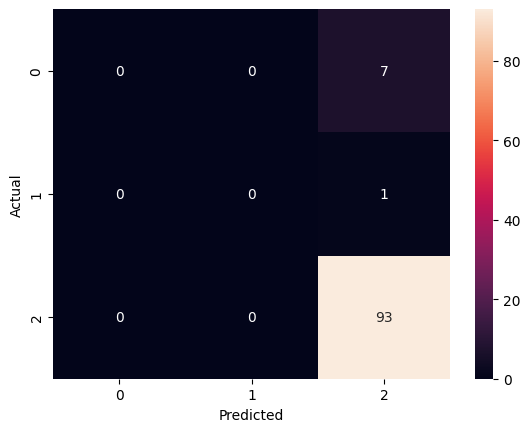

In [91]:
sns.heatmap(cm_test,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix is a 3x3 array, indicating that the classification problem has three classes (let's call them Class 0, Class 1, and Class 2). Each cell in the matrix represents the number of instances for the corresponding true and predicted class.

**Inference:**
The model correctly classifies all instances of Class 2.



### **Building Model on TDM**

In [92]:
naive_model = MultinomialNB()
naive_model.fit(train_X_tdm,train_Y)

MultinomialNB()

In [93]:
predict_test = naive_model.predict(test_X_tdm)

In [94]:
len(predict_test)

101

In [95]:
print('Accuracy on test: ',metrics.accuracy_score(test_Y,predict_test))

Accuracy on test:  0.9207920792079208


In [96]:
# predict probabilities test
predict_prob_test = naive_model.predict_proba(test_X_tdm)

In [97]:
predict_prob_test

array([[2.04983399e-04, 6.60697938e-07, 9.99794356e-01],
       [1.25695380e-02, 9.71607280e-05, 9.87333301e-01],
       [8.14829984e-06, 2.47975187e-07, 9.99991604e-01],
       [1.46598515e-05, 5.79233414e-07, 9.99984761e-01],
       [1.75299154e-06, 1.37104205e-07, 9.99998110e-01],
       [2.91975089e-05, 9.54000009e-07, 9.99969848e-01],
       [4.71988675e-07, 1.97142732e-08, 9.99999508e-01],
       [2.61768488e-05, 1.95459601e-06, 9.99971869e-01],
       [1.23357985e-02, 3.33789886e-04, 9.87330412e-01],
       [3.38015016e-08, 7.07397390e-10, 9.99999965e-01],
       [3.23140209e-03, 3.01986751e-04, 9.96466611e-01],
       [1.60310429e-06, 1.53128295e-08, 9.99998382e-01],
       [4.98895603e-09, 8.76626428e-11, 9.99999995e-01],
       [4.49314110e-04, 4.52785943e-05, 9.99505407e-01],
       [1.85363056e-06, 1.15209023e-07, 9.99998031e-01],
       [5.70363465e-04, 5.45240700e-05, 9.99375112e-01],
       [2.11198674e-07, 7.87149541e-09, 9.99999781e-01],
       [5.96542446e-05, 3.18546

In [98]:
# confusion matrix on test
cm_test = metrics.confusion_matrix(test_Y,predict_test)

In [99]:
cm_test

array([[ 0,  0,  7],
       [ 0,  0,  1],
       [ 0,  0, 93]])

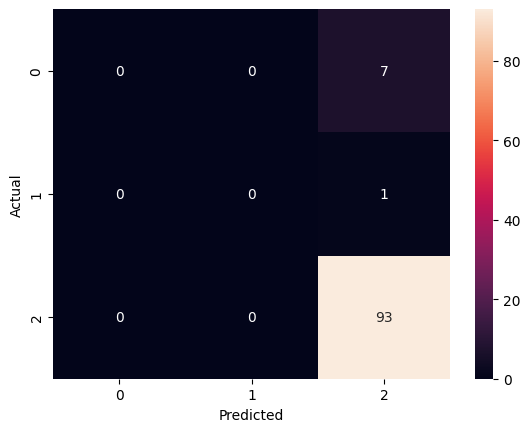

In [100]:
sns.heatmap(cm_test,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Same here, all 93 instances of Class 2 were correctly classified as Class 2.

### **Topic Modelling**

In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents.
* Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body.
* Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently.
* A document typically concerns multiple topics in different proportions.
* The "topics" produced by topic modeling techniques are clusters of similar words.
* A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.

* Topic models are also referred to as probabilistic topic models, which refers to statistical algorithms for discovering the latent semantic structures of an extensive text body.
* In the age of information, the amount of the written material we encounter each day is simply beyond our processing capacity.
* Topic models can help to organize and offer insights for us to understand large collections of unstructured text bodies.
* Originally developed as a text-mining tool, topic models have been used to detect instructive structures in data such as genetic information, images, and networks.
* They also have applications in other fields such as bioinformatics and computer vision.

### **Latent Dirichlet Allocation (LDA)**

Latent Dirichlet Allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model and belongs to the machine learning field and in a wider sense to the artificial intelligence field.


><img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*VK5R_2YlRx3NbRIMbUxJ8Q.png">


The word ‘Latent’ indicates that the model discovers the ‘yet-to-be-found’ or hidden topics from the documents. ‘Dirichlet’ indicates LDA’s assumption that the distribution of topics in a document and the distribution of words in topics are both Dirichlet distributions. ‘Allocation’ indicates the distribution of topics in the document.  

LDA assumes that documents are composed of words that help determine the topics and maps documents to a list of topics by assigning each word in the document to different topics. The assignment is in terms of conditional probability estimates. It is important to note that LDA ignores the order of occurrence of words and the syntactic information. It treats documents just as a collection of words or a bag of words.

In [101]:
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=50)
X_topics = lda_model.fit_transform(train_X_dtm)
topic_word = lda_model.components_
vocab = vect.get_feature_names_out()

- **n_components: Number of topics to unearth from the documents**
- **learning_method: Method used to update '_component'; Only used in fit method; In general, if the data size is large, the online update will be much faster than the batch update**

   - Valid options:

   'batch': Batch variational Bayes method. Use all training data in
    each EM update.
    Old `components_` will be overwritten in each iteration.

   'online': Online variational Bayes method. In each EM update, use
    mini-batch of training data to update the ``components_``
    variable incrementally. The learning rate is controlled by the
    ``learning_decay`` and the ``learning_offset`` parameters.

- **components_: Variational parameters for topic word distribution. Since the complete conditional for topic word distribution is a Dirichlet, components_[i, j] can be viewed as pseudocount that represents the number of times word j was assigned to topic i. It can also be viewed as distribution over the words for each topic after normalization: model.components_ / model.components_.sum(axis=1)[:, np.newaxis].**

In [102]:
# view the topic models
top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print(topic_words)

['did' 'said' 'spoke' 'received' 'called' 'reached' 'sent' 'receive'
 'paying' 'asked']
['recommend' 'great' 'nt' 'did' 'work' 'knowledgeable' 'worked' 'best'
 'helpful' 'working']
['amazing' 'expected' 'preapproval' 'closed' '30' 'good' 'total' 'honest'
 '2300' '600']
['nt' 'work' 'true' 'come' 'explained' 'making' 'happier' 'need' 'went'
 'best']
['read' 'emailed' 'called' 'going' 'calling' 'forward' 'spoke' 'know' 'nt'
 'interested']
['best' 'got' 'complicated' 'work' 'buy' 'tough' 'tried' 'thorough'
 'closed' 'close']
['responsive' 'informative' 'extremely' 'highly' 'recommend' 'impressed'
 'close' 'communicate' 'happier' 'financing']
['professional' 'competitive' 'getting' 'work' 'timely' 'satisfied'
 'called' 'online' 'signing' 'real']
['previous' 'recommend' 'did' 'nt' 'right' 'exceeded' 'trusted' 'involved'
 'closed' 'went']
['make' 'took' 'felt' 'gave' 'financial' 'like' 'feel' 'different' 'quite'
 'explain']


**For instance,**

- Topics 2 and 3 are all about the positive experiences that the customers associated with their respective banks while availing the latter's services

- Topic 4 and 6 on the other hand, possibly talks about the poor experience faced by the customers.

**End of Notebook**